In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#get direct and trigger PMT data from hdf5 file
fData = h5py.File('no_filter/nf.hdf5','r')
print(fData.keys())
trigger = fData['channel1']
direct = fData['channel2']

#get direct PMT dark pulse background from hdf5 file
fNoise = h5py.File('no_data/nd.hdf5','r')
print(fNoise.keys())
directNoise = fNoise['channel2']

#print array type and size
print(trigger.dtype, trigger.shape)
print(direct.dtype, direct.shape)
print(directNoise.dtype, directNoise.shape)

#check to make sure both channels have the same time division (should be 0.4 ns)
print(trigger.attrs['horiz_interval'])
print(direct.attrs['horiz_interval'])
print(directNoise.attrs['horiz_interval'])

#get x and y scales of all channels
dx = trigger.attrs['horiz_interval'] #time divisions in seconds 
dy_t = trigger.attrs['vertical_gain'] #trigger gain in volts
dy_d = direct.attrs['vertical_gain'] #direct gain in volts
dy_dN = directNoise.attrs['vertical_gain'] #directNoise gain in volts

<KeysViewHDF5 ['channel1', 'channel2']>
<KeysViewHDF5 ['channel1', 'channel2']>
int8 (1000000, 502)
int8 (1000000, 502)
int8 (1000000, 502)
4.000000053405728e-10
4.000000053405728e-10
4.000000053405728e-10


In [2]:
#-------------------------------------#
#harcdoded variables that can change
#-------------------------------------#

#data dimensions
window_length = 502
num_traces = 1e6
num_plots = 1e4 #takes too long to plot them all

#trigger thresholds defined in Tanner's paper
min_pulse_time = 3 #ns - must be above 20% of peak voltage for this time
min_pulse_voltage = 8e-4 #threshold voltage - half the max noise amplitude  # 8e-4

termination_ohms = 50 #to calculate PMT charges

#convert window length to time in ns
ns = 1e9
time = np.arange(0,window_length)
time = time*dx*ns
print(dx*ns)
print(time[-1])
print(dy_t, dy_d)

0.4000000053405728
200.40000267562698
0.004291660618036985 9.411225619260222e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1703.61it/s]


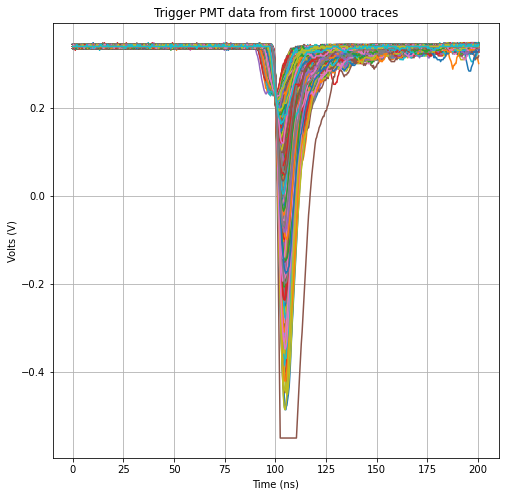

In [3]:
#plot trigger data from first few traces
plt.figure(figsize=(8,8))
for i in tqdm(range(int(num_plots))):
    plt.plot(time,trigger[i]*dy_t)
plt.title("Trigger PMT data from first " + str(int(num_plots)) + " traces")
plt.xlabel("Time (ns)")
plt.ylabel("Volts (V)")
plt.grid()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1564.89it/s]


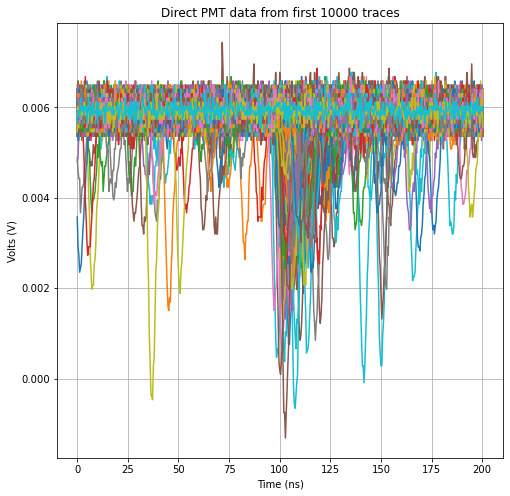

In [4]:
#plot direct data from first few traces
plt.figure(figsize=(8,8))
for i in tqdm(range(int(num_plots))):
    plt.plot(time,direct[i]*dy_d)
plt.title("Direct PMT data from first " + str(int(num_plots)) + " traces")
plt.xlabel("Time (ns)")
plt.ylabel("Volts (V)")
plt.grid()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1375.61it/s]


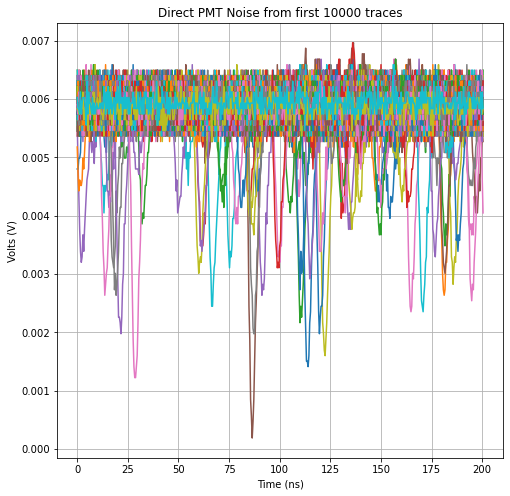

In [5]:
#plot directNoise data from first few traces
plt.figure(figsize=(8,8))
for i in tqdm(range(int(num_plots))):
    plt.plot(time,directNoise[i]*dy_dN)
plt.title("Direct PMT Noise from first " + str(int(num_plots)) + " traces")
plt.xlabel("Time (ns)")
plt.ylabel("Volts (V)")
plt.grid()

In [6]:
#finds peak (minimum) in a given data range
def findPeak(data, start, end):
    peak = np.mean(data)
    index = 0
    for i in range(int(start), int(end)):
        if data[i] < peak:
            peak = data[i]
            index = i
    return peak, index

#finds average in a given data range
def findAvg(data, start, end):
    avg = 0
    for i in range(start, end):
        avg += data[i]
    return avg/(end-start)

In [7]:
#find the trigger and direct pedestal averages from the first 100 traces to use for the rest
j = 100
trigger_pedestal_avg = 0
direct_pedestal_avg = 0
for i in range(j):
    #convert data from trace to volts
    trigger_data = trigger[i]*dy_t
    direct_data = direct[i]*dy_d
    #find trigger peak and where it happens
    trigger_peak, trigger_peak_index = findPeak(trigger_data, 0, window_length)
    #set pedestal windows - don't want to include any signal
    trigger_pedestal = trigger_peak_index-50 
    #careful - don't include any direct noise (just so happens no dark pulses before trigger peak in first 100 traces)
    direct_pedestal = trigger_peak_index-50
    #find pedestal average for trigger and direct channels (just the average noise)
    trigger_pedestal_avg += findAvg(trigger_data, 0, trigger_peak_index-50)
    direct_pedestal_avg += findAvg(direct_data, 0, trigger_peak_index-50)
trigger_pedestal_avg = trigger_pedestal_avg/j
direct_pedestal_avg = direct_pedestal_avg/j
directNoise_pedestal_avg = direct_pedestal_avg

Text(0, 0.5, 'Voltage (V)')

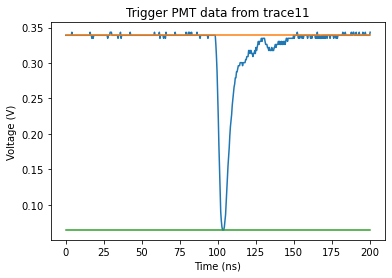

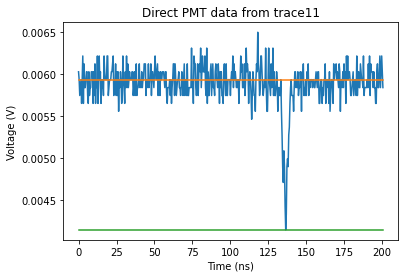

In [8]:
#plot example where both PMTs trigger - trace11 direct saw a dark pulse

#convert data from trace11 to volts
trigger_data = trigger[10]*dy_t
direct_data = direct[10]*dy_d

#make arrays for plotting to debug
trigger_peak_line = np.full(window_length,findPeak(trigger_data, 0, window_length)[0])
direct_peak_line = np.full(window_length,findPeak(direct_data, 0, window_length)[0])
trigger_pedestal_avg_line = np.full(window_length,findAvg(trigger_data, 0, trigger_pedestal))
direct_pedestal_avg_line = np.full(window_length,findAvg(direct_data, 0, direct_pedestal))

plt.figure()
plt.plot(time,trigger_data)
plt.plot(time,trigger_pedestal_avg_line)
plt.plot(time,trigger_peak_line)
plt.title("Trigger PMT data from trace11")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")

plt.figure()
plt.plot(time,direct_data)
plt.plot(time,direct_pedestal_avg_line)
plt.plot(time,direct_peak_line)
plt.title("Direct PMT data from trace11")
plt.xlabel("Time (ns)")
plt.ylabel("Voltage (V)")

In [9]:
# Tanner's paper -https://arxiv.org/abs/1811.11587
# "This is done by scanning the digitized waveform of the transmission PMT looking for a threshold crossing that is 3
# times larger than the width of the electronics noise. If the threshold is crossed for longer than 3 ns, the 
# analysis flags the threshold crossing as associated with a true PMT pulse, rather than a spike in the electronics
# noise. The peak of the PMT pulse is identified, and the sample associated with the 20% peak-height crossing is
# found. This sample is taken as the time of the PMT pulse for the transmission PMT. The same is done for the trigger"

# dark count freq is ~50 Hz
# beta day freq is ~1KHz

In [10]:
#find time where the pulse first crosses 20% of the peak value 
def findCrossings(data, peak, peak_index, pedestal_avg):
    #find the start and end times of the 20% peak-height
    i = 0
    start = 0
    #search to the left of the peak - max 50 samples (20 ns)
    while peak_index-i >= 0 and i < 50 and pedestal_avg-data[peak_index-i] > 0.2*(pedestal_avg-peak):
            start = peak_index-i
            i+=1
    i = 0
    end = 0
    #search to the right of the peak - max 100 samples (40 ns - pulses have a longer tail)
    while peak_index+i < window_length and i<100 and pedestal_avg-data[peak_index+i] > 0.2*(pedestal_avg-peak):
            end = peak_index+i
            i+=1
    return start, end

#integrate over time and divide by termination resistace of PMT to get total charge in pico Coloumbs
def calcCharge(data, peak, peak_index, pedestal_avg):
    start, end = findCrossings(data, peak, peak_index, pedestal_avg)
    #integrate
    charge = 0
    for i in range(start, end):
        voltage = pedestal_avg-data[i]
        charge+=(1000*voltage*dx*ns)/termination_ohms
    return charge

  0%|▎                                                                                                                                                             | 2227/1000000 [00:02<15:29, 1073.28it/s]

Event 2047 had a direct time of 0.0


  0%|▋                                                                                                                                                             | 4227/1000000 [00:03<14:35, 1136.90it/s]

Event 4170 had a direct time of 0.0


  2%|███▏                                                                                                                                                         | 20187/1000000 [00:20<15:19, 1065.38it/s]

Event 20058 had a direct time of 0.0


  2%|███▌                                                                                                                                                          | 22910/1000000 [00:22<18:03, 901.52it/s]

Event 22765 had a direct time of 0.0


  3%|████▊                                                                                                                                                        | 30627/1000000 [00:30<15:00, 1076.94it/s]

Event 30485 had a direct time of 0.0


  6%|█████████▋                                                                                                                                                    | 61479/1000000 [01:04<16:24, 953.01it/s]

Event 61376 had a trigger time of 134.80000179977304


 12%|██████████████████                                                                                                                                           | 115274/1000000 [02:08<23:40, 623.02it/s]

Event 115192 had a trigger time of 130.40000174102673


 23%|███████████████████████████████████▉                                                                                                                         | 228581/1000000 [05:33<36:07, 355.98it/s]

Event 228556 had a trigger time of 147.60000197067137


 24%|█████████████████████████████████████▌                                                                                                                       | 239515/1000000 [05:57<37:00, 342.56it/s]

Event 239468 had a trigger time of 113.60000151672267


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 412340/1000000 [14:37<43:37, 224.54it/s]

Event 412312 had a trigger time of 192.00000256347494


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [1:14:05<00:00, 224.95it/s]


Detected 48804 direct pulses from 1000000 trigger pulses.
Detected 9283 dark pulses from 1000000 separate trigger pulses.


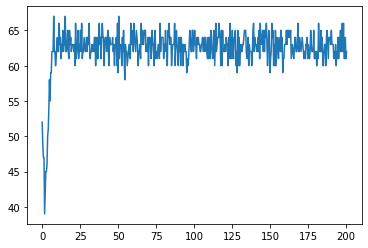

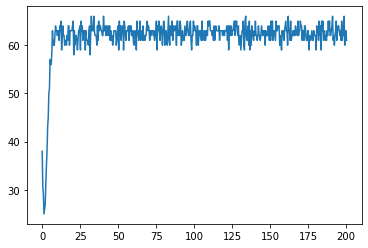

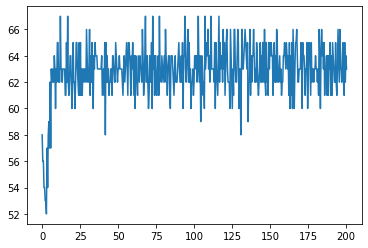

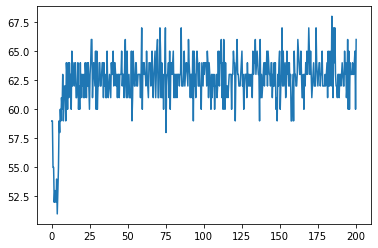

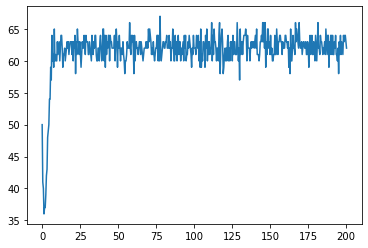

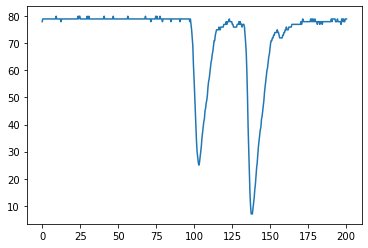

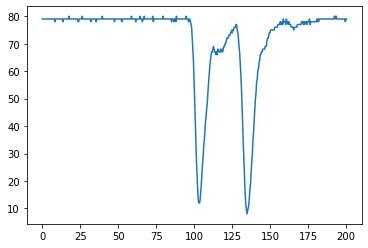

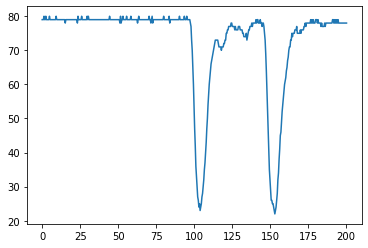

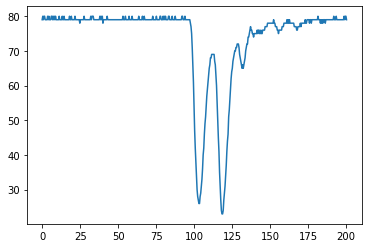

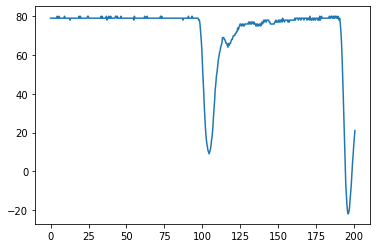

In [11]:
#main
trigger_peak = np.zeros([int(num_traces)])
trigger_peak_index = np.zeros([int(num_traces)])
trigger_charge = np.zeros([int(num_traces)])
trigger_time = np.zeros([int(num_traces)])

direct_peak = []
direct_peak_index = []
direct_charge = []
direct_time = []

relative_time = []

directNoise_peak = []
directNoise_peak_index = []
directNoise_charge = []
directNoise_time = []

weird_triggers=0
weird_directs=0

#loop through every trace
for i in tqdm(range(int(num_traces))):
    
    # --Trigger--
    #find what and when the peak was
    trigger_peak[i], trigger_peak_index[i] = findPeak(trigger[i]*dy_t, 0, window_length)
    #calculate the charge of the pulse
    trigger_charge[i] = calcCharge(trigger[i]*dy_t, trigger_peak[i], int(trigger_peak_index[i]), trigger_pedestal_avg)
    #find where it crossed the 20% threshold
    trigger_time[i] = findCrossings(trigger[i]*dy_t, trigger_peak[i], int(trigger_peak_index[i]), trigger_pedestal_avg)[0]*dx*ns
    if trigger_time[i]>110 and weird_triggers<5:
        print("Event " + str(i) + " had a trigger time of " + str(trigger_time[i]))
        plt.figure()
        plt.plot(time, trigger[i])
        weird_triggers+=1
        
    # --Direct--
    #find what and when the peak was
    direct_peak = np.append(direct_peak, findPeak(direct[i]*dy_d, 0, window_length)[0])
    direct_peak_index = np.append(direct_peak_index, findPeak(direct[i]*dy_d, 0, window_length)[1])
    #see if the peak was above the minimum pulse voltage
    if direct_pedestal_avg-direct_peak[i] > min_pulse_voltage:
        #find where it crossed the 20% threshold
        start, end = findCrossings(direct[i]*dy_d, direct_peak[i], int(direct_peak_index[i]), direct_pedestal_avg)
        #if the peak crosses for more than the minimum pulse time
        if (end-start)*dx*ns > 3:
            #store the time of the pulse
            direct_time = np.append(direct_time, start*dx*ns)
            relative_time = np.append(relative_time, (start*dx*ns-trigger_time[i]))
            #calculate the charge 
            direct_charge = np.append(direct_charge, calcCharge(direct[i]*dy_d, direct_peak[i], int(direct_peak_index[i]), direct_pedestal_avg))
            if direct_time[-1]==0 and weird_directs<5:
                print("Event " + str(i) + " had a direct time of " + str(direct_time[-1]))
                plt.figure()
                plt.plot(time,direct[i])
                weird_directs+=1
                
    # --DirectNoise--
    #find what and when the directNoise peak was
    directNoise_peak = np.append(directNoise_peak, findPeak(directNoise[i]*dy_dN, 0, window_length)[0])
    directNoise_peak_index = np.append(directNoise_peak_index, findPeak(directNoise[i]*dy_dN, 0, window_length)[1])
    #see if the peak was above the minimum pulse voltage
    if directNoise_pedestal_avg-directNoise_peak[i] > min_pulse_voltage:
        #find where it crossed the 20% threshold
        start, end = findCrossings(directNoise[i]*dy_dN, directNoise_peak[i], int(directNoise_peak_index[i]), directNoise_pedestal_avg)
        #if the peak crosses for more than the minimum pulse time
        if (end-start)*dx*ns > 3:
            #store the time of the pulse
            directNoise_time = np.append(directNoise_time, start*dx*ns)
            #calculate the charge 
            directNoise_charge = np.append(directNoise_charge, calcCharge(directNoise[i]*dy_dN, directNoise_peak[i], int(directNoise_peak_index[i]), directNoise_pedestal_avg))
     
            
print("Detected " + str(len(direct_charge)) + " direct pulses from " + str(int(num_traces)) + " trigger pulses.") 
print("Detected " + str(len(directNoise_charge)) + " dark pulses from " + str(int(num_traces)) + " separate trigger pulses.") 

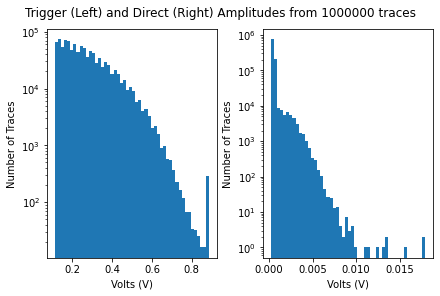

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")
fig.suptitle("Trigger (Left) and Direct (Right) Amplitudes from " + str(int(num_traces)) + " traces")

ax1.hist(trigger_pedestal_avg-trigger_peak, bins=50)
ax1.set_xlabel("Volts (V)")
ax1.set_ylabel("Number of Traces")
ax1.set_yscale("log")

#this might mean the min direct amplitude is too low - maybe seeing a bit of noise - but charges look good below

ax2.hist(direct_pedestal_avg-direct_peak, bins=50)
ax2.set_xlabel("Volts (V)")
ax2.set_ylabel("Number of Traces")
ax2.set_yscale("log")

#excess of high trigger amplitudes because some pulses got cut off by the scope window

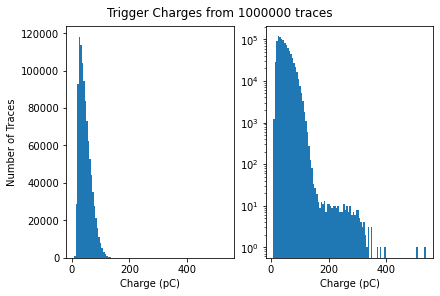

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")
fig.suptitle("Trigger Charges from " + str(int(num_traces)) + " traces")

ax1.hist(trigger_charge, bins=100)
ax1.set_xlabel("Charge (pC)")
ax1.set_ylabel("Number of Traces")

ax2.hist(trigger_charge, bins=100)
ax2.set_xlabel("Charge (pC)")
ax2.set_yscale("log")

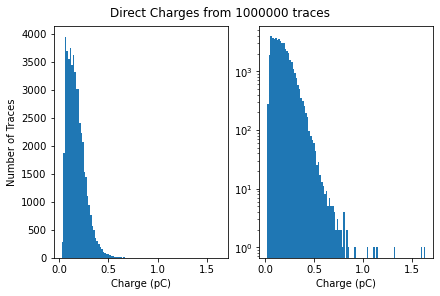

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")
fig.suptitle("Direct Charges from " + str(int(num_traces)) + " traces")

ax1.hist(direct_charge, bins=100)
ax1.set_xlabel("Charge (pC)")
ax1.set_ylabel("Number of Traces")

ax2.hist(direct_charge, bins=100)
ax2.set_xlabel("Charge (pC)")
ax2.set_yscale("log")

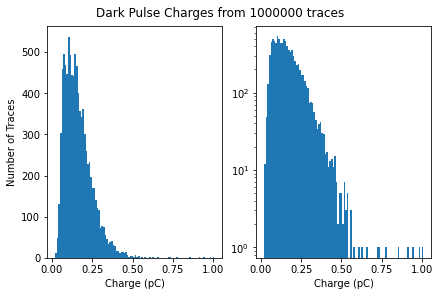

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")
fig.suptitle("Dark Pulse Charges from " + str(int(num_traces)) + " traces")

ax1.hist(directNoise_charge, bins=100)
ax1.set_xlabel("Charge (pC)")
ax1.set_ylabel("Number of Traces")

ax2.hist(directNoise_charge, bins=100)
ax2.set_xlabel("Charge (pC)")
ax2.set_yscale("log")

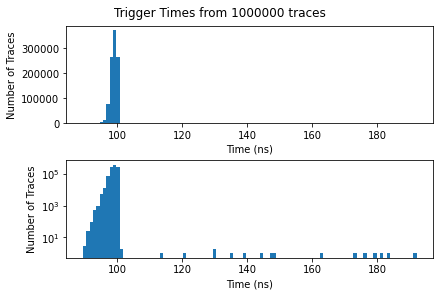

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
fig.suptitle("Trigger Times from " + str(int(num_traces)) + " traces")

ax1.hist(trigger_time, bins=100)
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Number of Traces")

ax2.hist(trigger_time, bins=100)
ax2.set_xlabel("Time (ns)")
ax2.set_ylabel("Number of Traces")
ax2.set_yscale("log")

#the weird late trigger are from after pulses or two photons being emitted - shown above

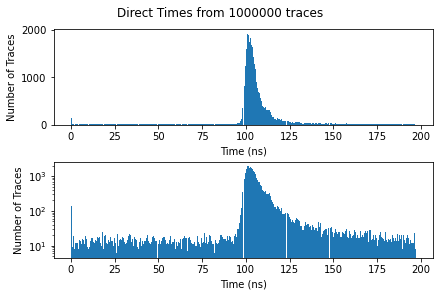

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
fig.suptitle("Direct Times from " + str(int(num_traces)) + " traces")

ax1.hist(direct_time, bins=501)
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Number of Traces")

ax2.hist(direct_time, bins=501)
ax2.set_xlabel("Time (ns)")
ax2.set_ylabel("Number of Traces")
ax2.set_yscale("log")

#not sure why a few bins are missing - no worries just for debugging

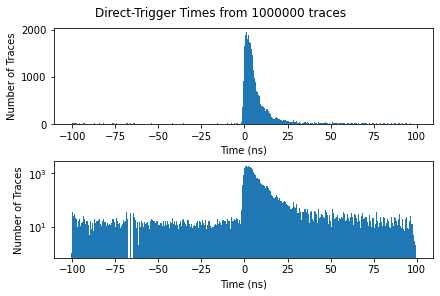

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
fig.suptitle("Direct-Trigger Times from " + str(int(num_traces)) + " traces")

ax1.hist(relative_time, bins=501)
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Number of Traces")

ax2.hist(relative_time, bins=501)
ax2.set_xlabel("Time (ns)")
ax2.set_ylabel("Number of Traces")
ax2.set_yscale("log")

#bin issue is sorted out below - this is just for debugging

(-3.0, 13.0)

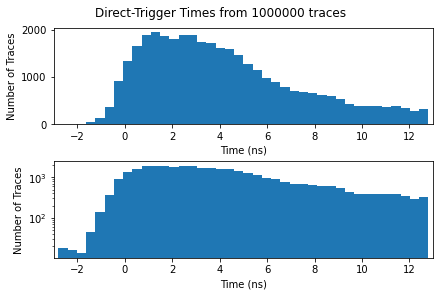

In [19]:
window_of_interest = []
for time in relative_time:
    if time>-3 and time<13:
        window_of_interest = np.append(window_of_interest, time)

fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")
fig.suptitle("Direct-Trigger Times from " + str(int(num_traces)) + " traces")

ax1.hist(window_of_interest, bins=40)
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Number of Traces")
ax1.set_xlim(-3,13)

ax2.hist(window_of_interest, bins=40)
ax2.set_xlabel("Time (ns)")
ax2.set_ylabel("Number of Traces")
ax2.set_yscale("log") 
ax2.set_xlim(-3,13)

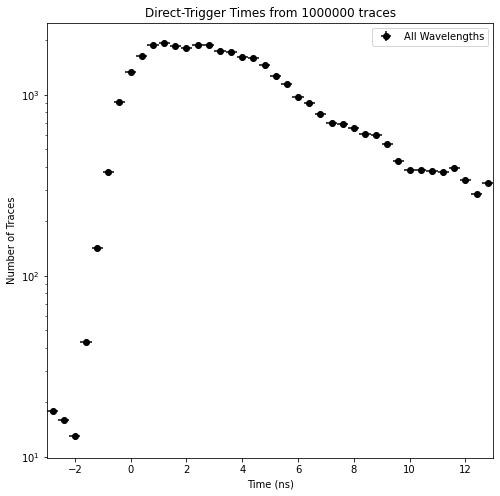

In [20]:
counts, binEdges = np.histogram(window_of_interest, bins=40, range=(-3,13))
binCenters = (binEdges[:-1] + binEdges[1:])/2
binWidth = (binEdges[1] - binEdges[0])/2
error = np.sqrt(counts)/counts

plt.figure(figsize=(8,8))
plt.errorbar(binCenters, counts, xerr=binWidth, yerr=error, fmt='ko', label='All Wavelengths')
plt.title("Direct-Trigger Times from " + str(int(num_traces)) + " traces")
plt.xlabel("Time (ns)")
plt.ylabel("Number of Traces")
plt.yscale("log")
plt.xlim(-3,13)
plt.legend(loc='upper right')

[144  22  23  21  18  24  20  23  10  22  24  25  16  17  17  19  20  12
  21  15  17  17  23  15  20  19  22  23  18  25  18  17  17  13  20  18
  19  18  15  12  16  19  17  18  11  25  14  16  11  21  15  12  25  25
  10  26  18  20  19  17  16  22  32  16  27  18  20  15  16  22  11  13
  16  17  23   9  15  21  14  21  18  20  18  18  19  22  17  17  21  18
  20  17  15  15  20  20  19  17  24  26  20  23  28  17  12  19  18  18
  13  16  10  24  18  14  16  13  19  14  14   7  28  17  24  18  24  19
  21  14  12  15  28  29  22  21  23  24  20  19  14  23  20  16  22  17
  20  26  20  21  25  13  25  14  22  13  18  16  16  20  18  16  14  16
  20  27  13  16  20  12  15  26  21  15  30  16  16  14  16  17  31  22
  14  20  12  22  15  20  22  16  20  20  18  13  14  17  20  19  19  15
  19  17  25  11  20  23  18  14  19  18  23  14  18  15  12  16  17  15
  19  23  17  21  13  16  20  18  22  18  17  16  24  20  24  13  23  16
  13  15  22  18  14  21  19  15  16  21  16  18  1

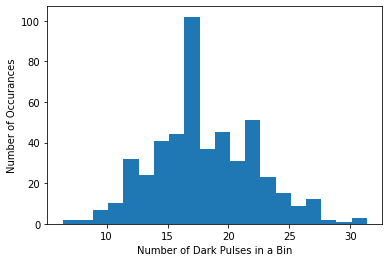

In [37]:
#find average number of dark pulses 
#excluding excess in the first window and defecit in the last few due 
#this is due to setting the time as when the pulse crosses the 20% peak-height

noise, edges = np.histogram(directNoise_time, bins=501, range=(0,200.4))
centers = (edges[:-1] + edges[1:])/2
width = (edges[1] - edges[0])/2

print(noise)

noise = np.delete(noise,0)
for i in range(7):
    noise = np.delete(noise, -1)       

plt.figure()
plt.hist(noise, bins="auto", align="left")
plt.xlabel("Number of Dark Pulses in a Bin")
plt.ylabel("Number of Occurances")

mean_noise = np.mean(noise)
sigma = np.std(noise)
print("Mean: " + str(mean_noise))
print("Sigma: " + str(std))

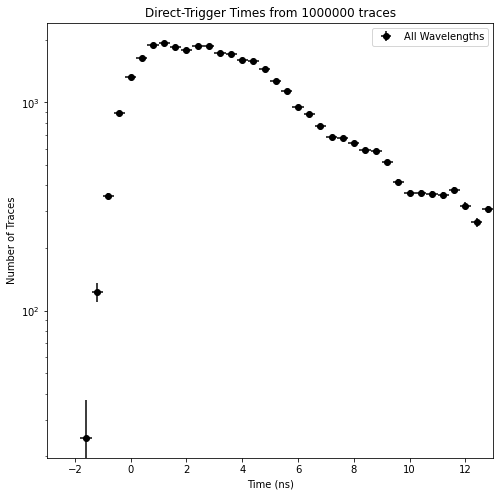

In [51]:
#make final plot

plt.figure(figsize=(8,8))
plt.errorbar(binCenters, counts-mean_noise, xerr=binWidth, yerr=error+3*sigma, fmt='ko', label='All Wavelengths')
plt.title("Direct-Trigger Times from " + str(int(num_traces)) + " traces")
plt.xlabel("Time (ns)")
plt.ylabel("Number of Traces")
plt.yscale("log")
plt.xlim(-3,13)
plt.legend(loc='upper right')